In [2]:
import pandas as pd
from sklearn import svm

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
train.drop(train[(train['mean_slope'] == "--") | (train['std_slope'] == "--")].index, inplace=True)
train.isin(["--"]).any()


image_file         False
hand               False
leg                False
hip                False
shoulder           False
mixed              False
label              False
perimeter          False
nm_lns             False
mean_length        False
std_length         False
mean_slope         False
std_slope          False
max_acute_angle    False
min_acute_angle    False
area               False
num_corners        False
corner_ratio       False
dtype: bool

In [5]:
test.drop(test[(test['mean_slope'] == "--") | (test['std_slope'] == "--")].index, inplace=True)
test.isin(["--"]).any()


image_file         False
hand               False
leg                False
hip                False
shoulder           False
mixed              False
label              False
perimeter          False
nm_lns             False
mean_length        False
std_length         False
mean_slope         False
std_slope          False
max_acute_angle    False
min_acute_angle    False
area               False
num_corners        False
corner_ratio       False
dtype: bool

In [6]:
from numpy import mean
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, cross_val_score
X_train = train.drop(columns=['image_file', 'label'])
y_train = train['label']

X_test = test.drop(columns=['image_file', 'label'])
y_test = test['label']


model = svm.SVC(gamma='scale')

balance = [{0:1, 1:2}, {0:1,1:4}, {0:1,1:5}]
param_grid = dict(class_weight=balance)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='f1')

grid_result = grid.fit(X_train, y_train)

# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.298341 using {'class_weight': {0: 1, 1: 5}}
0.024652 (0.026644) with: {'class_weight': {0: 1, 1: 2}}
0.173845 (0.056971) with: {'class_weight': {0: 1, 1: 4}}
0.298341 (0.049342) with: {'class_weight': {0: 1, 1: 5}}


In [7]:
from sklearn.metrics import classification_report, confusion_matrix
weigths = grid_result.best_params_['class_weight']
model = svm.SVC(gamma='scale', class_weight=weigths)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.80      0.82       674
           1       0.23      0.30      0.26       142

    accuracy                           0.71       816
   macro avg       0.54      0.55      0.54       816
weighted avg       0.74      0.71      0.72       816

Confusion Matrix:
[[536 138]
 [100  42]]


In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from sklearn.metrics import classification_report

# Define the model architecture
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'AUC', 'Precision', 'Recall'])
callback = EarlyStopping(monitor='AUC', patience=3)
# Fit the model to the training data
model.fit(np.asarray(X_train).astype('float32'), np.asarray(y_train).astype('float32'), epochs=30, batch_size=64, class_weight={0: 1, 1: 3}, callbacks=[callback])

Epoch 1/30
51/51 [==============================] - 1s 11ms/step - loss: 6.3304 - accuracy: 0.6082 - auc: 0.5351 - precision: 0.2005 - recall: 0.4108
Epoch 2/30
51/51 [==============================] - 0s 8ms/step - loss: 1.6109 - accuracy: 0.6916 - auc: 0.5572 - precision: 0.2316 - recall: 0.3252
Epoch 3/30
51/51 [==============================] - 0s 7ms/step - loss: 2.2747 - accuracy: 0.6676 - auc: 0.5526 - precision: 0.2249 - recall: 0.3636
Epoch 4/30
51/51 [==============================] - 0s 7ms/step - loss: 1.3755 - accuracy: 0.6937 - auc: 0.5664 - precision: 0.2330 - recall: 0.3234
Epoch 5/30
51/51 [==============================] - 0s 7ms/step - loss: 2.1833 - accuracy: 0.6704 - auc: 0.5405 - precision: 0.2178 - recall: 0.3374
Epoch 6/30
51/51 [==============================] - 0s 6ms/step - loss: 1.6482 - accuracy: 0.6943 - auc: 0.5857 - precision: 0.2452 - recall: 0.3549
Epoch 7/30
51/51 [==============================] - 0s 7ms/step - loss: 1.8303 - accuracy: 0.6694 - auc: 

In [43]:
# Predict on the test data
y_pred = model.predict(np.asarray(X_test).astype('float32'))

# Convert predictions to binary labels
y_pred_binary = np.round(y_pred)

# Generate classification report
report = classification_report(np.asarray(y_test).astype('float32'), y_pred_binary)
print("Classification Report:")
print(report)

26/26 [==============================] - 0s 2ms/step
Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.68      0.77       674
         1.0       0.27      0.58      0.37       142

    accuracy                           0.66       816
   macro avg       0.58      0.63      0.57       816
weighted avg       0.78      0.66      0.70       816



<Axes: >

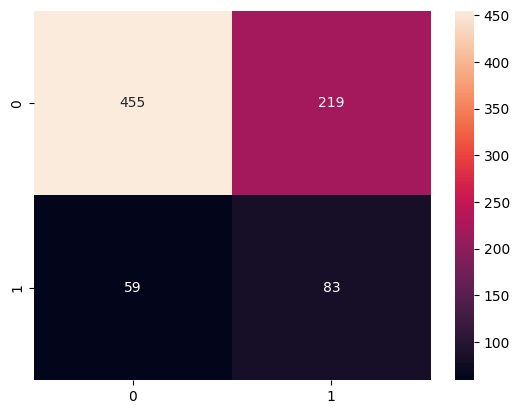

In [44]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

sns.heatmap(confusion_matrix(y_test,y_pred_binary),annot = True,fmt='d')
